# House Prices: Advanced Regression Techniques

In [37]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from scipy.stats import skew
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Get data
train = pd.read_csv('/home/kieran/Kaggle/AMES/train.csv')
test = pd.read_csv('/home/kieran/Kaggle/AMES/test.csv')

data = pd.concat([train, test], sort=True)

## Duplicates, Missing Data and Outliers

In [3]:
# Checking for duplicates
unique_pts = len(set(data.Id))
total_pts = data.shape[0]
duplicate_pts = total_pts - unique_pts
print('There are {0} duplicate entries from {1} total.'.format(duplicate_pts, total_pts))

There are 0 duplicate entries from 2919 total.


In [4]:
# Finding missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing Points', 'Percent Missing'])
missing_data.head(35)

,Total Missing Points,Percent Missing
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageCond,159,0.054471
GarageQual,159,0.054471


So there are 34 columns with missing data points. Many of these are explained in the documentation as being representative of absence of a feature, or a value of 0 (or can be reasonably inferred to stand for these things).

The ones that cannot be filled in this way are: MSZoning, Utilities, Functional, Exterior1st, Exterior2nd, SaleType, Electrical, and KitchenQual. These we will fill with the most common value in their column.

In [5]:
incomplete_cols = data.columns[data.isnull().sum() > 0].tolist()
mode_cols = ['MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical', 
             'KitchenQual']
null_cols = [x for x in incomplete_cols if x not in mode_cols]

for col in mode_cols:
    mode = data[col].mode()
    data[col].fillna(mode[0], inplace=True)
    
for col in null_cols:
    if data[col].dtype == 'object':
        data[col].fillna('None', inplace=True)
    else:
        data[col].fillna(0, inplace=True)

There is undoubtedly more we could do here, such as making sure that values we have filled as 'None' in 'MasVnrType' correspond to 'MasVnrArea' values of 0. In fact looking at the differences in the numbers of missing values for the various basement related variables, we have almost certainly made mistakes like this. 

However correcting for these would probably be a poor use of time for an exercise like this, especially considering any case the variables where this would be a problem all have less than 3% of values missing to begin with.

In [6]:
# The documentation recommends removing points with more than 4000 square feet of living area
data = data[data.GrLivArea <= 4000]

## Visualisation and Exploration

We'll visualize the relationships between the sale price and those variables which seem like they will be interesting or have a high correlation to sale price.

/home/kieran/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


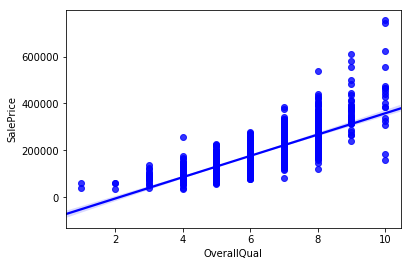

In [7]:
# As expected, price is strongly correlated with overall quality
_ = sns.regplot(x='OverallQual', y='SalePrice', data=train, color='blue')

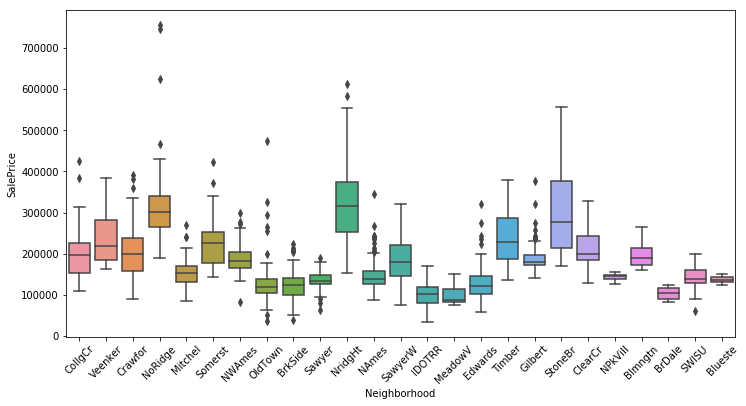

In [8]:
# Neighbourhood
_ = plt.figure(figsize=(12,6))
_ = sns.boxplot(x='Neighborhood', y='SalePrice', data=train)
_ = plt.xticks(rotation=45)

As expected, neighbourhood has a large effect on house price. The 'NoRidge' suburb has what seems like two outlier points, we will consider removing them at the end to see if it improves the model.

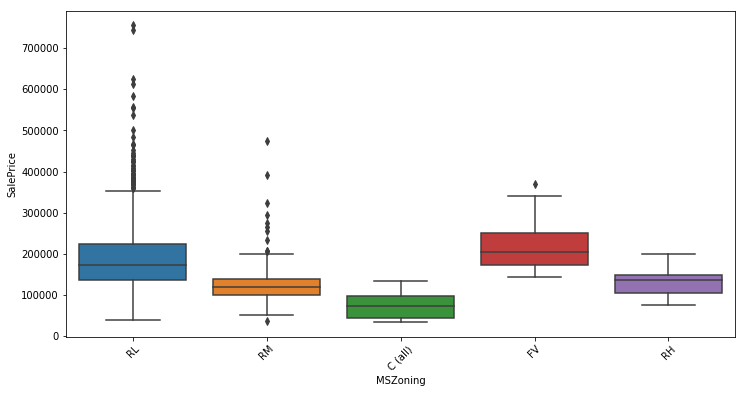

In [9]:
# Zoning classification
_ = plt.figure(figsize=(12,6))
_ = sns.boxplot(x='MSZoning', y='SalePrice', data=train)
_ = plt.xticks(rotation=45)

The different zones seem to have clearly defined price ranges, as expected, with residential low density having very much the largest spread. Floating village housing is the most expensive type which makes sense, though I would have expected more differentiation between medium and high density residential housing. Again we can see the two outliers from NoRidge.

/home/kieran/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


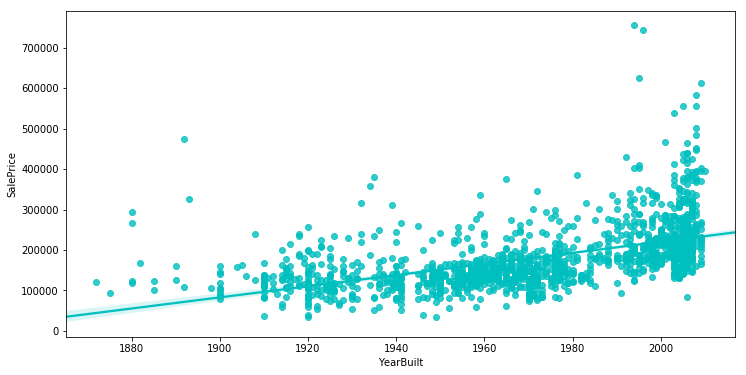

In [10]:
# Sale price by year seems to show a general increase over time, most markedly since about the 1970s
_ = plt.figure(figsize=(12,6))
_ = sns.regplot(x='YearBuilt', y='SalePrice', data=train, color='c')

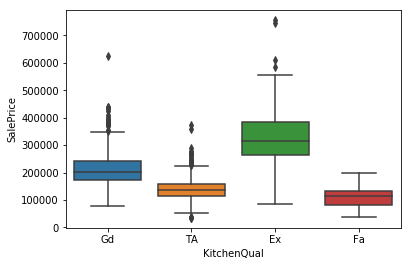

In [11]:
# Kitchen quality
_ = sns.boxplot(x='KitchenQual', y='SalePrice', data=train)

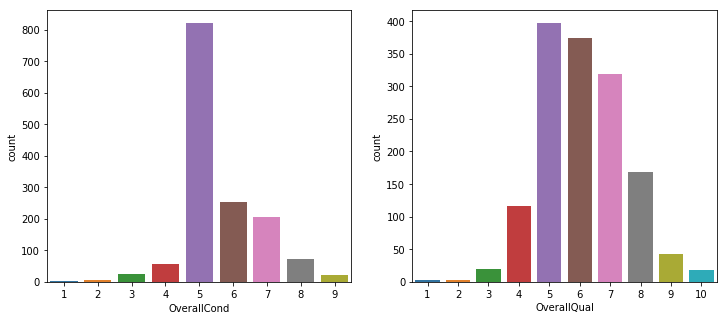

In [12]:
# While quality is normally distributed, overall condition of houses is mainly average.
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
_ = sns.countplot(x='OverallCond', data=train, ax=ax[0])
_ = sns.countplot(x='OverallQual', data=train, ax=ax[1])

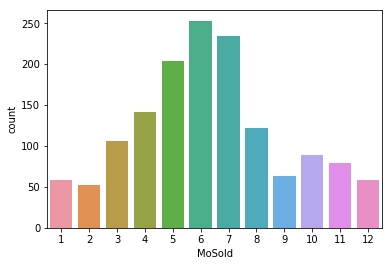

In [13]:
# This was interesting to me, by far more houses are sold in the summer than in the colder months
_ = sns.countplot(x='MoSold', data=train)

## Feature Engineering

This will consist of some great ideas regarding categorical variables which I unashamedly stole from this notebook:

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

We will also log-transform any features thats have a skew of more than 0.75.

In [14]:
# Some numerical features are actually really categories
data = data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

# Encode some categorical features as ordered numbers when there is information in the order
data = data.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [15]:
# Create new features
# 3* Polynomials on the top 10 existing features
## Find most correlated features:
corr = data.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
top_variables = corr.SalePrice.iloc[1:11]
top_variables = top_variables.axes[0].tolist()

In [16]:
## Create sqrt, **2 and **3 polynomials for the top ten variables
for x in top_variables:
    sq = x + '-sq'
    s2 = x + '-^2'
    s3 = x + '-^3'
    data[sq] = np.sqrt(data[x])
    data[s2] = data[x]**2
    data[s3] = data[x]**3

In [17]:
# One-hot encoding categorical features
data = pd.get_dummies(data)

In [18]:
# Log transforming skewed features (for skew > 0.75), and log-transforming the target variable
for col in data.columns:
    if skew(data[col]) > 0.75:
        data[col] = np.log1p(data[col])

y = train['SalePrice'].values
y = np.log1p(y)

## Modelling 

### Preparation 

In [19]:
# Re-partitioning the dataset into train and test
split_location = train.shape[0]
train = data.iloc[:split_location].reset_index(drop=True)
test = data.iloc[split_location:].reset_index(drop=True)

In [20]:
# Standardizing numerical features
std_scaler = StandardScaler(copy=False)
std_scaler.fit(train)

train = std_scaler.transform(train)
test = std_scaler.transform(test)

StandardScaler(copy=False, with_mean=True, with_std=True)

In [21]:
from sklearn.model_selection import KFold

#Validation function
n_folds = 5

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Models

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

MAPE on Training set : 2.1046746838453685


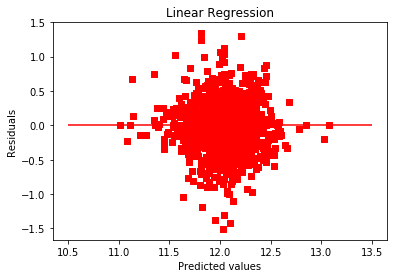

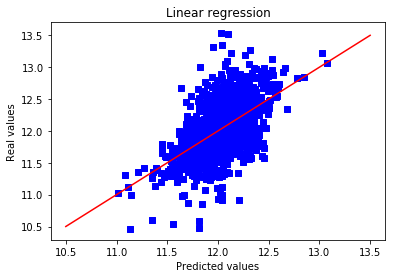

In [22]:
### 1st Linear Regression Without regularisation
lr = LinearRegression()
lr.fit(train, y)

# Look at predictions on training and validation set
y_pred = lr.predict(train)
print("MAPE on Training set :", mean_absolute_percentage_error(y, y_pred))

# Residuals plot
_ = plt.scatter(y_pred, y_pred - y, c='red', marker='s')
_ = plt.title('Linear Regression')
_ = plt.xlabel("Predicted values")
_ = plt.ylabel("Residuals")
_ = plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
_ = plt.scatter(y_pred, y, c = "blue", marker = "s", label = "Training data")
_ = plt.title("Linear regression")
_ = plt.xlabel("Predicted values")
_ = plt.ylabel("Real values")
_ = plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [23]:
### LASSO Regression
# We use sklearn's Robustscaler() method to make LASSO less sensitive to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(tol=0.01, random_state=1))
_ = lasso.fit(train, y)

# Look at predictions on training and validation set
y_pred = lasso.predict(train)
print("MAPE on Training set :", mean_absolute_percentage_error(y, y_pred))


MAPE on Training set : 2.54156172669684


In [24]:
### Elastic Net Regression
# Again using Robustscaler()
ENet = make_pipeline(RobustScaler(), ElasticNetCV(tol = 0.01, l1_ratio=.9, random_state=3))
_ = ENet.fit(train, y)

# Look at predictions on training and validation set
y_pred = ENet.predict(train)
print("MAPE on Training set :", mean_absolute_percentage_error(y, y_pred))

MAPE on Training set : 2.5415642908946197


In [25]:
### Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
_ = KRR.fit(train, y)

# Look at predictions on training and validation set
y_pred = KRR.predict(train)
print("MAPE on Training set :", mean_absolute_percentage_error(y, y_pred))

MAPE on Training set : 1.29563157806829


In [26]:
### Gradient Boosting Regression
# Using Huber loss function to make the regressor more robust to outliers 
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
_ = GBoost.fit(train, y)

# Look at predictions on training and validation set
y_pred = GBoost.predict(train)
print("MAPE on Training set :", mean_absolute_percentage_error(y, y_pred))

MAPE on Training set : 0.481659602208919


In [30]:
### XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, nthread = -1)
_ = model_xgb.fit(train, y)

# Look at predictions on training and validation set
y_pred = model_xgb.predict(train)
print("MAPE on Training set :", mean_absolute_percentage_error(y, y_pred))

MAPE on Training set : 0.6796168173404307


In [35]:
### LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
_ = model_lgb.fit(train, y)

# Look at predictions on training and validation set
y_pred = model_lgb.predict(train)
print("MAPE on Training set :", mean_absolute_percentage_error(y, y_pred))

MAPE on Training set : 1.4125032690762178


## Stacking

Here I use a method of meta-stacking which I took from this notebook: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard, which contains a full explanation. First we build a stacking class:

In [38]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

This stacking class does not provide a way of setting tolerance parameters for any of the models. This leads to convergence warnings, although obviously the model does eventually converge and we get a score. It may also be that this is why the score is so bad (we would have expected it to be better than all our models but it's actually among the worst), this is something to look into later on when I have time.

In [46]:
# We use lasso regression as our meta-model for stacking and use it to combine all the other models
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, model_xgb, model_lgb, lasso),
                                                 meta_model = GBoost)

_ = stacked_averaged_models.fit(train, y)
y_pred = stacked_averaged_models.predict(train)

score = mean_absolute_percentage_error(y, y_pred)

print(score)

/home/kieran/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/kieran/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/kieran/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/kieran/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

1.9371509047964814
